In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, Bidirectional, LSTM, LayerNormalization, RepeatVector, Dense, Concatenate, TimeDistributed, Lambda

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import shutil
import os
import seaborn as sns

/tmp/ipykernel_108320/2469995650.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = pd.to_datetime(data['id'], errors='ignore')
/tmp/ipykernel_108320/2469995650.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))


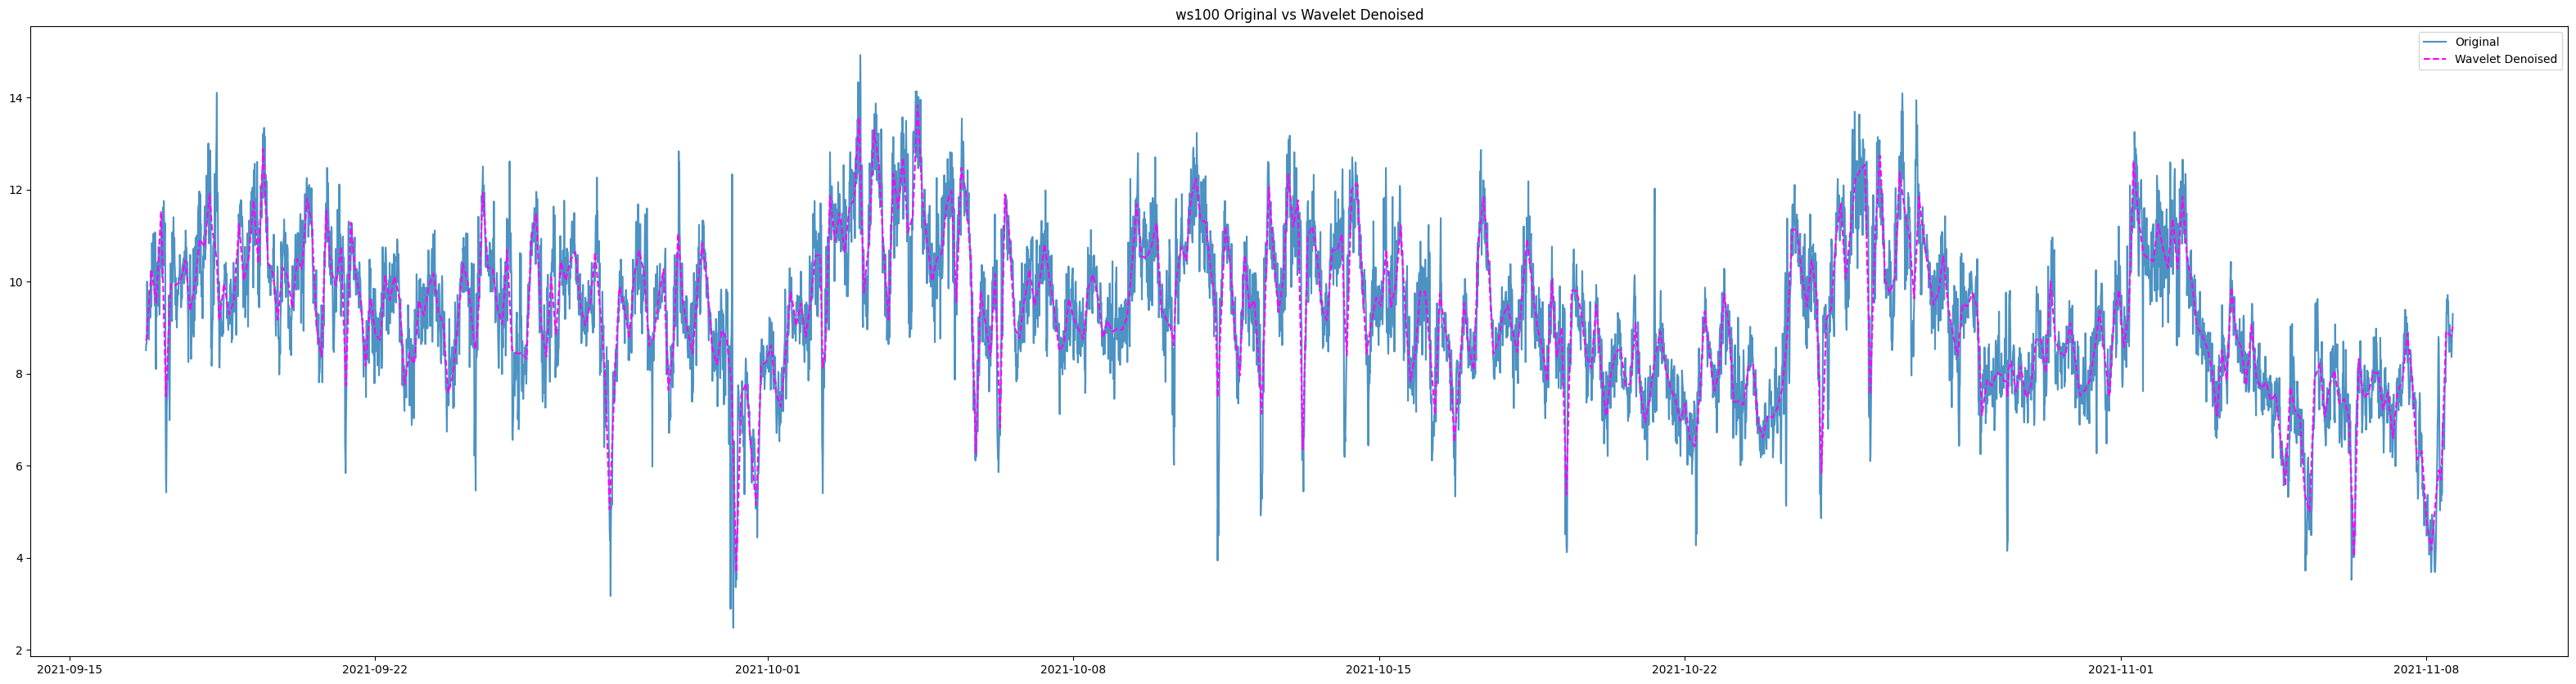

Matriz de Correlação entre os Componentes de Tendência:
                     ws100_wavelet  humid_wavelet  wdisp100_wavelet  \
ws100_wavelet             1.000000      -0.450274          0.676428   
humid_wavelet            -0.450274       1.000000         -0.719829   
wdisp100_wavelet          0.676428      -0.719829          1.000000   
temp_wavelet              0.275961      -0.904013          0.616083   
vertdisp100_wavelet       0.428749      -0.856791          0.851956   

                     temp_wavelet  vertdisp100_wavelet  
ws100_wavelet            0.275961             0.428749  
humid_wavelet           -0.904013            -0.856791  
wdisp100_wavelet         0.616083             0.851956  
temp_wavelet             1.000000             0.869147  
vertdisp100_wavelet      0.869147             1.000000  


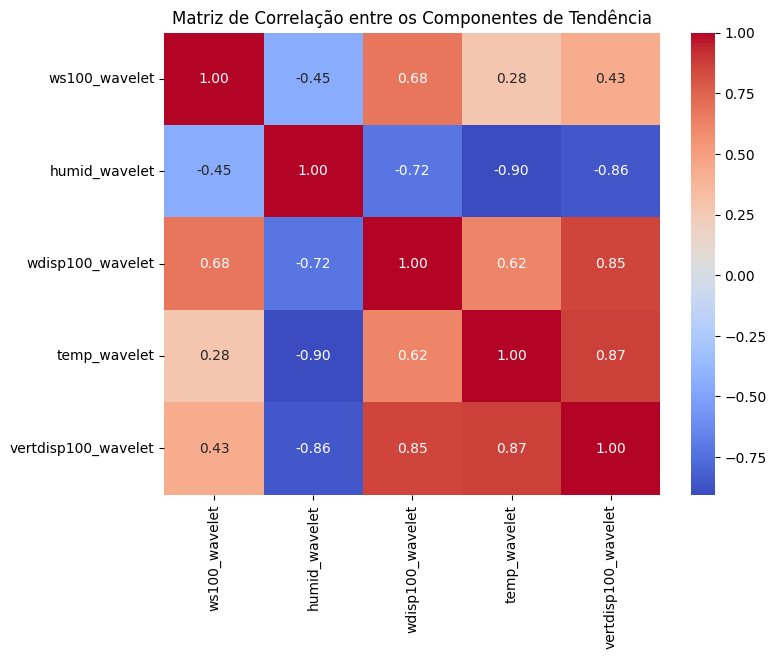

In [ ]:
data = pd.read_csv("dataset.csv")
data.index = pd.to_datetime(data['id'], errors='ignore')
data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))

variables = pd.DataFrame(index=data.index)

def wavelet_denoising(signal, wavelet='bior2.2', level=4):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    return reconstructed_signal

for col in ['ws100', 'humid', 'wdisp100', 'temp', 'vertdisp100']:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal[:len(data)]  
    else:
        raise ValueError(f"A coluna {col} não existe no dataset.")
    
plt.figure(figsize=(40, 10))
plt.plot(data.index, data['ws100'], label='Original', alpha=0.8)
plt.plot(variables.index, variables['ws100_wavelet'], label='Wavelet Denoised', linestyle='--', color='magenta')
plt.title('ws100 Original vs Wavelet Denoised')
plt.legend()
plt.show()

correlation_matrix = variables.corr()

print("Matriz de Correlação entre os Componentes de Tendência:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre os Componentes de Tendência')
plt.show()

scaler_ws100 = MinMaxScaler()
variables_scaled_ws100 = scaler_ws100.fit_transform(variables[['ws100_wavelet']])

scaler_other = MinMaxScaler()
variables_scaled_other = scaler_other.fit_transform(variables.drop(columns=['ws100_wavelet']))

variables_scaled = np.hstack((variables_scaled_ws100, variables_scaled_other))
variables_scaled = pd.DataFrame(
    variables_scaled, 
    columns=variables.columns, 
    index=variables.index
)



Valor calculado de delta (80th percentile): 0.1858479190652741


Model: "Bidirectional_LSTM_Seq2Seq_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 36, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 36, 128)   │     35,840 │ encoder_inputs[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm_0      │ (None, 36, 128)   │        256 │ bidirectional_14… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 36, 128)   │          0 │ encoder_norm_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 128)       │          0 │ dropout_49[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 6, 128)    │          0 │ get_item_14[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_0      │ (None, 6, 128)    │    131,584 │ repeat_vector_14… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_norm_0      │ (None, 6, 128)    │        256 │ decoder_lstm_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 6, 128)    │          0 │ decoder_norm_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 6, 128)    │    197,888 │ dropout_49[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_50[0][0], │
│                     │                   │            │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 6, 64)     │      8,256 │ multihead_attent… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 6, 192)    │          0 │ dropout_50[0][0], │
│ (Concatenate)       │                   │            │ attention_dense[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        193 │ concatenate_21[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 6)         │          0 │ output_layer[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 374,273 (1.43 MB)

 Trainable params: 374,273 (1.43 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento da execução 1/1
Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 0.0609 - mae: 0.3936 - val_loss: 0.0064 - val_mae: 0.0546 - learning_rate: 1.0000e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 0.0203 - mae: 0.1585 - val_loss: 0.0057 - val_mae: 0.0444 - learning_rate: 1.0000e-04
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 0.0128 - mae: 0.1082 - val_loss: 0.0061 - val_mae: 0.0559 - learning_rate: 1.0000e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - loss: 0.0080 - mae: 0.0708 - val_loss: 0.0050 - val_mae: 0.0431 - learning_rate: 1.0000e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 0.0065 - mae: 0.0602 - val_loss: 0.0046 - val_mae: 0.0424 - learning_rate: 1.0000e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - loss: 0.0053 - mae: 0.0525 - val_loss: 0.0039 - val_mae: 0.0379 - learning_rate: 1.0000e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 0.

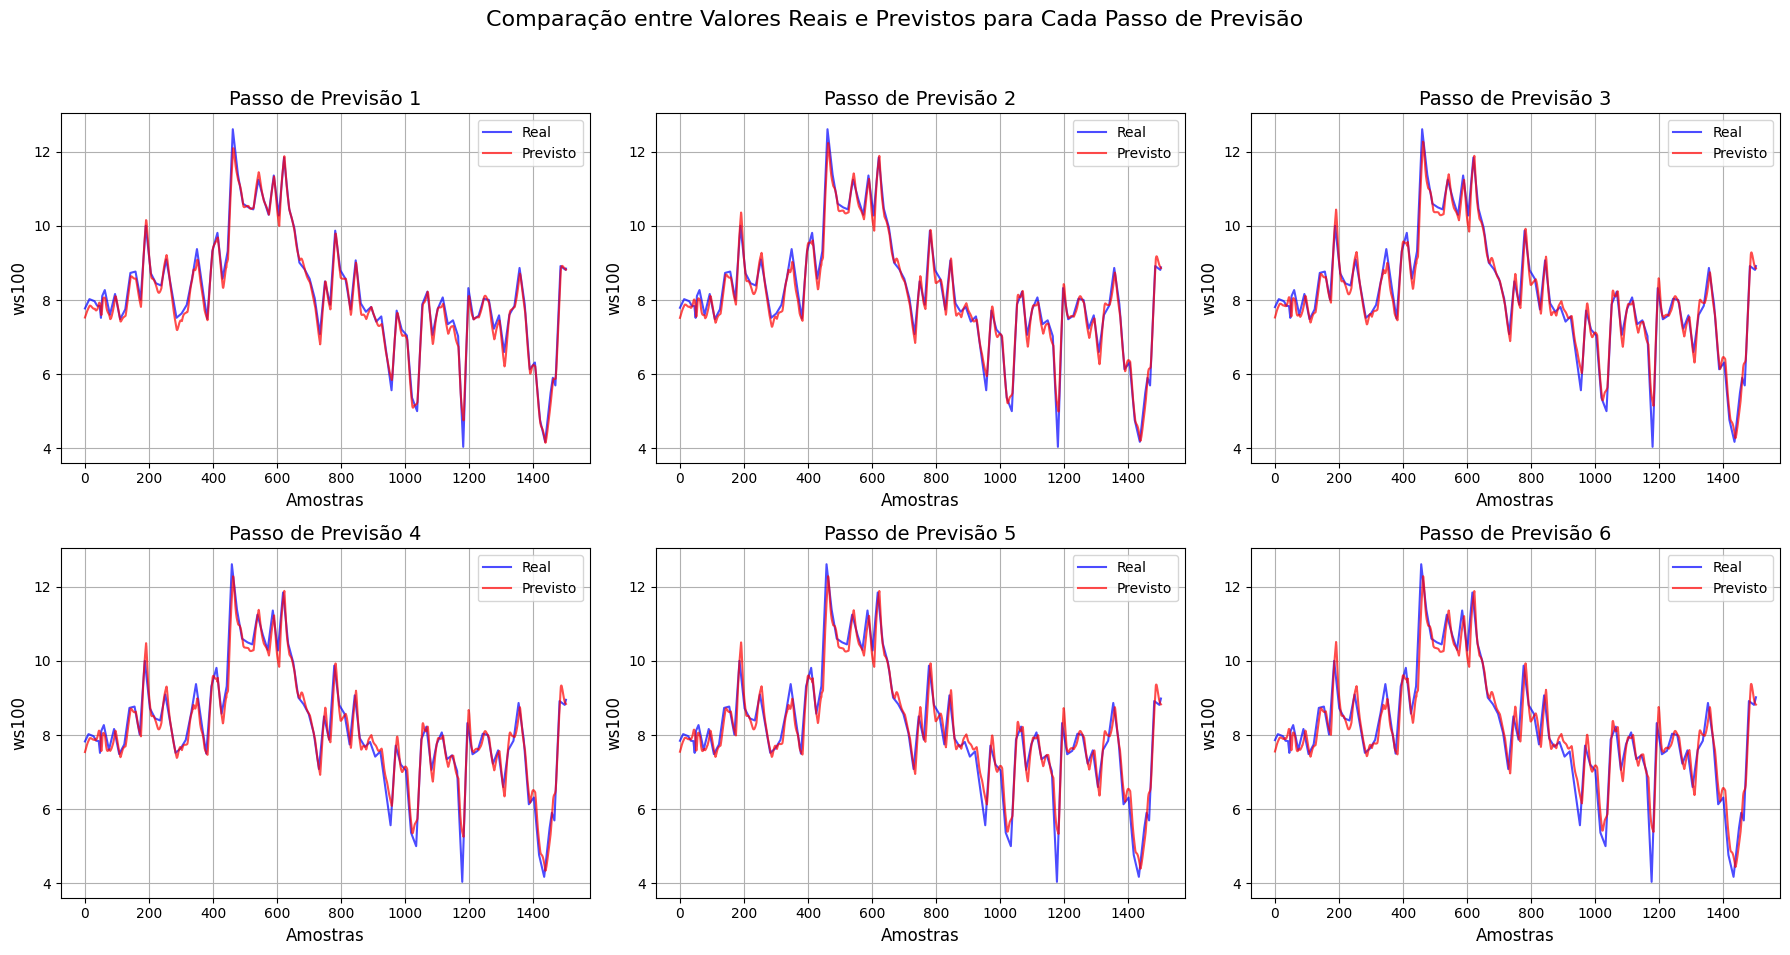

In [ ]:
input_steps = 36
output_steps = 6

def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps)])
        y.append(data[(i + input_steps):(i + input_steps + output_steps), 0])  
    return np.array(X), np.array(y)

data_array = variables_scaled.values

X, y = create_sequences(data_array, input_steps, output_steps)

split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
ws100_values = variables_scaled_ws100.flatten()

abs_deviation = np.abs(ws100_values - np.mean(ws100_values))

delta = np.percentile(abs_deviation, 80)

print(f"Valor calculado de delta (80th percentile): {delta}")

def custom_huber_loss(y_true, y_pred):
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss

In [ ]:
def build_model(input_steps, num_features, output_steps):
    num_layers = 1
    units = 64
    dropout_rate = 0.1

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
        if dropout_rate > 0:
                encoder_outputs = tf.keras.layers.Dropout(dropout_rate)(encoder_outputs)

    context_vector = encoder_outputs  
    
    decoder_inputs = RepeatVector(output_steps)(encoder_outputs[:, -1, :]) 
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=units * 2,
            return_sequences=True,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
        if dropout_rate > 0:
            decoder_outputs = tf.keras.layers.Dropout(dropout_rate)(decoder_outputs)
 
    attention_layer = MultiHeadAttention(num_heads=6, key_dim=units, name='multihead_attention')
    attention_output = attention_layer(query=decoder_outputs, value=context_vector, key=context_vector)

    attention_dense = Dense(units, activation='tanh', name='attention_dense')
    attention_output = attention_dense(attention_output)

    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(outputs) 
    
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq_with_Attention')
    
    model.compile(
        optimizer=optimizer,
        loss=custom_huber_loss,
        metrics=['mae']
    )
    
    return model

In [ ]:
num_runs = 1

num_features = X_train.shape[2]
model = build_model(input_steps, num_features, output_steps)

model.summary()

best_val_loss = float('inf')
best_model_path = 'best_model.h5.keras'


for run in range(1, num_runs + 1):
    print(f"\nIniciando o treinamento da execução {run}/{num_runs}")
    
    model = build_model(input_steps, num_features, output_steps)
    
    temp_checkpoint = f'best_model_run{run}.h5.keras'
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(temp_checkpoint, monitor='val_loss', save_best_only=True)
    ]
    
    history = model.fit(
        X_train, y_train, 
        epochs=100,  
        batch_size=32, 
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    run_best_val_loss = min(history.history['val_loss'])
    print(f"Melhor val_loss na execução {run}: {run_best_val_loss}")
    
    if run_best_val_loss < best_val_loss:
        print(f"A execução {run} melhorou o val_loss global. Salvando o modelo como o melhor.")
        best_val_loss = run_best_val_loss
        shutil.copyfile(temp_checkpoint, best_model_path)
    else:
        print(f"A execução {run} não melhorou o val_loss global.")
    
    os.remove(temp_checkpoint)

print(f"\nTreinamento completo. Melhor val_loss alcançado: {best_val_loss}")

In [ ]:
model.load_weights(best_model_path)

y_pred = model.predict(X_test)

y_test_inversed = scaler_ws100.inverse_transform(y_test)
y_pred_inversed = scaler_ws100.inverse_transform(y_pred)

output_steps = 6

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação entre Valores Reais e Previstos para Cada Passo de Previsão', fontsize=16)

for step in range(output_steps):
    row = step // 3
    col = step % 3
    ax = axes[row, col]
    
    real = y_test_inversed[:, step]
    pred = y_pred_inversed[:, step]
    
    ax.plot(real, label='Real', color='blue', alpha=0.7)
    ax.plot(pred, label='Previsto', color='red', alpha=0.7)
    
    ax.set_title(f'Passo de Previsão {step + 1}', fontsize=14)
    ax.set_xlabel('Amostras', fontsize=12)
    ax.set_ylabel('ws100', fontsize=12)
    ax.legend()
    ax.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()